## Importing Packages

In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,precision_score, accuracy_score, f1_score, r2_score, precision_recall_curve, roc_curve


#modules for avoiding warnings
import warnings
warnings.filterwarnings('ignore')

#setting backend for matplotlib
%matplotlib inline

#setting formatting options
pd.options.display.max_columns = 100
pd.options.display.max_rows = 900
pd.set_option('float_format' , '{:f}'.format)

#setting plot style
plt.style.use('seaborn-darkgrid')
df= pd.read_csv("/Users/tevfikerkut/Downloads/fraudTrain.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df = df.iloc[:,1:]  # getting rid of unnamed column

In [5]:
# Number of unique values in the dataset

df.nunique()

trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64

In [6]:
# Null values

df.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [7]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])  # converting transaction time into datetime object

In [8]:
# Creating new columns from transaction time
df['tx_hour'] = df['trans_date_trans_time'].dt.hour
df['tx_dayofweek'] = df['trans_date_trans_time'].dt.day_name()
df['tx_month'] = df['trans_date_trans_time'].dt.to_period('M')

In [9]:
# Finding Age variable
# Converting 'dob' column to datetime object
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = np.round((df['trans_date_trans_time'] - 
                      df['dob'])/np.timedelta64(1, 'Y'))
df.age.tail()

1296670   59.000000
1296671   41.000000
1296672   53.000000
1296673   40.000000
1296674   25.000000
Name: age, dtype: float64

In [10]:
# Dropping unneeded variables
df.drop(['trans_date_trans_time','first', 'last', 'dob'] , axis=1, inplace=True)

In [12]:
# Our target variable is imbalanced
100*df.is_fraud.value_counts(normalize=True)

0   99.421135
1    0.578865
Name: is_fraud, dtype: float64

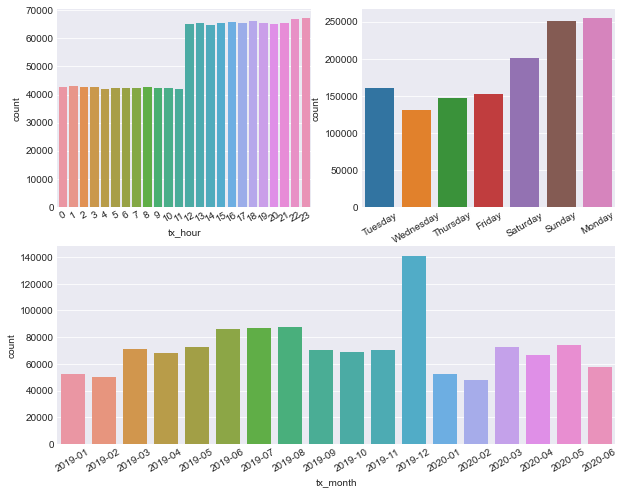

In [13]:
fix, ax = plt.subplots(figsize=(10,8))

plot = [0,0,0]
#plotting the 'tx_hour' feature
plot[0] = sns.countplot(df.tx_hour, ax = plt.subplot(221))
#plotting the 'tx_dayofweek' feature
plot[1] = sns.countplot(df.tx_dayofweek, ax = plt.subplot(222))
#plotting the 'tx_month' feature
plot[2] = sns.countplot(df.tx_month, ax = plt.subplot(212))

for i in plot:
  i.set_xticklabels(i.get_xticklabels(), rotation=30)
plt.show()

In [14]:
#year_month vs number of transactions
df_tx_periods = df.groupby(df['tx_month'])[['trans_num','cc_num']].nunique().reset_index()
df_tx_periods.columns = ['year_month','num_of_transactions','customers']
df_tx_periods

,year_month,num_of_transactions,customers
0,2019-01,52525,913
1,2019-02,49866,918
2,2019-03,70939,916
3,2019-04,68078,913
4,2019-05,72532,910
5,2019-06,86064,908
6,2019-07,86596,910
7,2019-08,87359,911
8,2019-09,70652,913
9,2019-10,68758,912


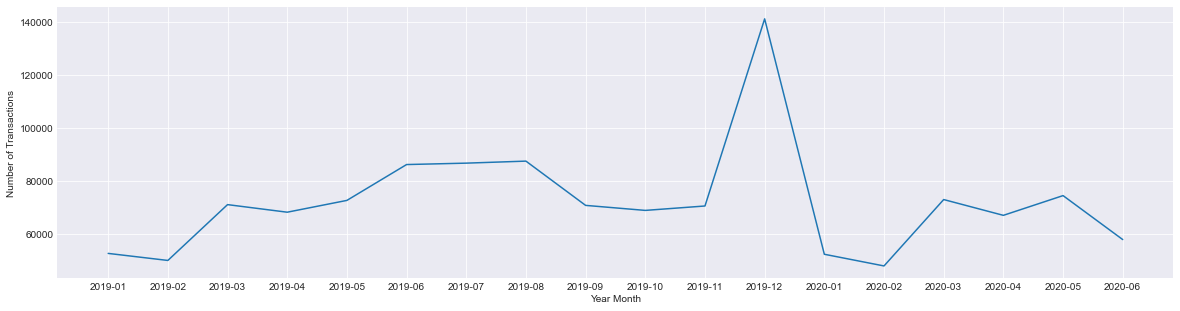

In [15]:
x = np.arange(0,len(df_tx_periods),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_tx_periods['num_of_transactions'])
ax.set_xticks(x)
ax.set_xticklabels(df_tx_periods['year_month'])

ax.set_xlabel('Year Month')
ax.set_ylabel('Number of Transactions')
plt.show()

In [16]:
df_fraud_transactions = df[df['is_fraud']==1]

df_customers = df_fraud_transactions.groupby(df_fraud_transactions['tx_month'])[['trans_num','cc_num']].nunique().reset_index()
df_customers.columns = ['year_month','num_of_fraud_transactions','fraud_customers']
df_customers

,year_month,num_of_fraud_transactions,fraud_customers
0,2019-01,506,50
1,2019-02,517,53
2,2019-03,494,49
3,2019-04,376,41
4,2019-05,408,42
5,2019-06,354,35
6,2019-07,331,36
7,2019-08,382,39
8,2019-09,418,44
9,2019-10,454,50


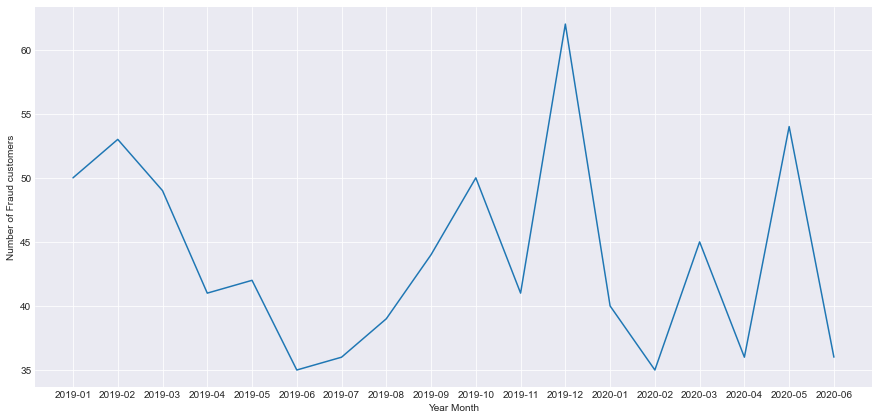

In [18]:
x = np.arange(0,len(df_customers),1)

fig, ax = plt.subplots(1,1,figsize=(15,7))
ax.plot(x,df_customers['fraud_customers'])
ax.set_xticks(x)
ax.set_xticklabels(df_customers['year_month'])

ax.set_xlabel('Year Month')
ax.set_ylabel('Number of Fraud customers')
plt.show()

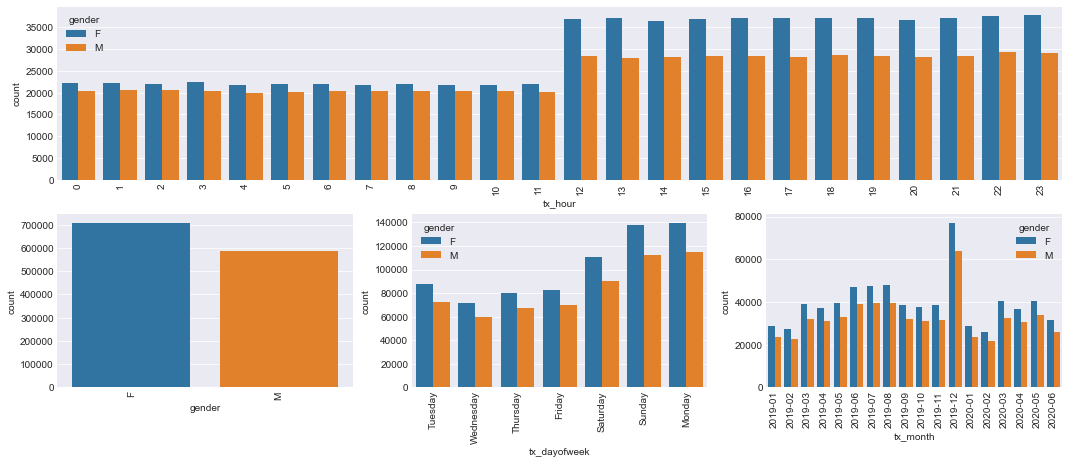

In [21]:
fig, ax = plt.subplots(figsize=(18,7))

plot = [0,0,0,0]

plot[0] = sns.countplot(df.tx_hour, hue=df.gender, ax=plt.subplot(211))
plot[1] = sns.countplot(df.gender, ax=plt.subplot(234))
plot[2] = sns.countplot(df.tx_dayofweek, hue=df.gender, ax=plt.subplot(235))
plot[3] = sns.countplot(df.tx_month, hue=df.gender, ax=plt.subplot(236))

for i in plot:
  i.set_xticklabels(i.get_xticklabels(), rotation=90)
plt.show()

In [26]:
#creating the 'gender' distributed dataframe
df_gender = df[['gender','trans_num']].groupby(['gender']).count().reset_index()
df_gender.columns = ['Gender', 'gender_count']

#creating gender-fraud distribution
df_fraud_gender = df[['gender','trans_num', 'is_fraud']].groupby(['gender','is_fraud']).count().reset_index()
df_fraud_gender.columns = ['Gender', 'is_fraud', 'Transaction Count']

df_fraud_gender = df_fraud_gender.merge(df_gender[['Gender', 'gender_count']], how='inner', on='Gender')

df_fraud_gender['Transaction percentage'] = (df_fraud_gender['Transaction Count']/df_fraud_gender['gender_count'])*100

df_fraud_gender

,Gender,is_fraud,Transaction Count,gender_count,Transaction percentage
0,F,0,706128,709863,99.473842
1,F,1,3735,709863,0.526158
2,M,0,583041,586812,99.357375
3,M,1,3771,586812,0.642625


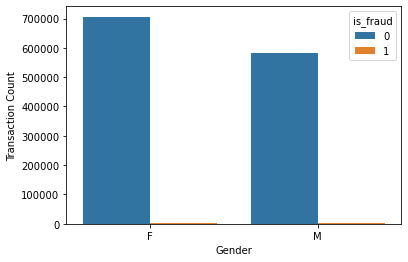

In [27]:
sns.barplot(data=df_fraud_gender, y='Transaction Count', x='Gender', hue='is_fraud')

plt.show()

In [22]:
# Segmenting age feature

for i in range(len(df.age)):
  if df.age[i] <= 30:
    df.age[i] = '< 30'
  elif df.age[i] > 30 and df.age[i] <= 45:
    df.age[i] = '30-45'
  elif df.age[i] > 45 and df.age[i] <= 60:
    df.age[i] = '46-60'
  elif df.age[i] > 60 and df.age[i] <= 75:
    df.age[i] = '61-75'
  else:
    df.age[i] = '> 75'

df.age.head()

0    30-45
1    30-45
2    46-60
3    46-60
4    30-45
Name: age, dtype: object

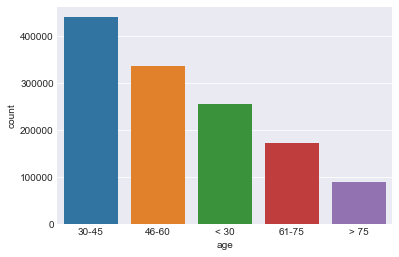

In [23]:
# Plotting the age feature in the data
plot = sns.countplot(df.age)

plt.show()

In [30]:
df_age = df[['age','trans_num']].groupby(['age']).count().reset_index()
df_age.columns = ['age', 'age_count']

# Creating age-fraud distribution
df_fraud_age = df[['age', 'trans_num', 'is_fraud']].groupby(['age','is_fraud']).count().reset_index()
df_fraud_age.columns = ['age', 'is_fraud', 'Transaction count']

df_fraud_age = df_fraud_age.merge(df_age[['age', 'age_count']], how='inner', on='age')

df_fraud_age['Transaction percentage'] = (df_fraud_age['Transaction count']/df_fraud_age['age_count'])*100

df_fraud_age

,age,is_fraud,Transaction count,age_count,Transaction percentage
0,30-45,0,438557,440411,99.579030
1,30-45,1,1854,440411,0.420970
2,46-60,0,334647,336814,99.356618
3,46-60,1,2167,336814,0.643382
4,61-75,0,170800,171904,99.357781
5,61-75,1,1104,171904,0.642219
6,< 30,0,255220,256759,99.400605
7,< 30,1,1539,256759,0.599395
8,> 75,0,89945,90787,99.072554
9,> 75,1,842,90787,0.927446


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


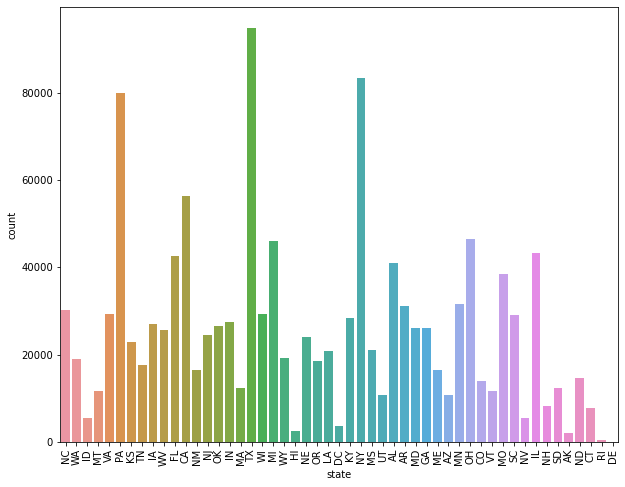

In [32]:
# State counts

fig, ax = plt.subplots(figsize=(10,8))
plot = sns.countplot(df.state)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.show()

In [24]:
print('Number of cities: ',df.city.nunique())
print('Number of zip codes: ',df.zip.nunique())

Number of cities:  894
Number of zip codes:  970


high frequencies cities:  ['Birmingham', 'San Antonio', 'Utica', 'Phoenix', 'Meridian', 'Thomas', 'Conway', 'Cleveland', 'Warren', 'Houston', 'Burbank', 'Naples', 'Arcadia', 'Indianapolis', 'Brandon', 'Fulton', 'Lahoma', 'Allentown', 'Lakeland', 'Dallas']
high frequencies zip codes:  [73754, 34112, 48088, 82514, 49628, 15484, 85173, 29819, 38761, 5461, 44233, 4287, 72042, 16858, 28405, 26292, 12419, 80120, 6024, 98238]


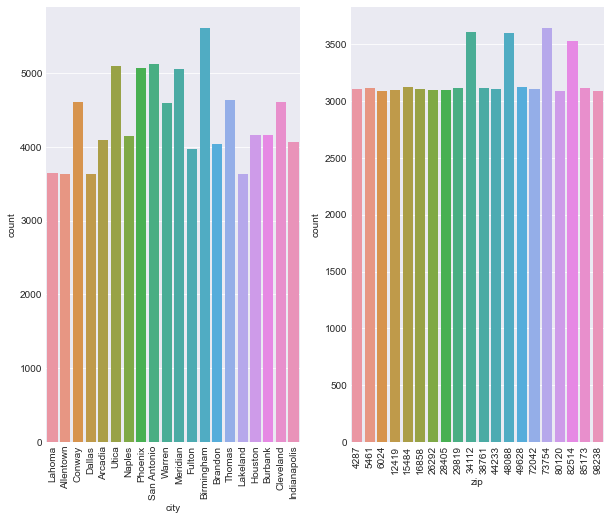

In [25]:
high_trans_cities = df.city.value_counts().head(20).index.tolist()
high_trans_zips = df.zip.value_counts().head(20).index.tolist()
print('high frequencies cities: ', high_trans_cities)
print('high frequencies zip codes: ', high_trans_zips)

fig, ax = plt.subplots(figsize=(10,8))
#plotting the cities transaction frequencies again
plots = []
plots.append(sns.countplot(df[df.city.isin(high_trans_cities)].city, ax=plt.subplot(121)))
plots.append(sns.countplot(df[df.zip.isin(high_trans_zips)].zip, ax=plt.subplot(122)))

for i in plots:
  i.set_xticklabels(i.get_xticklabels(), rotation=90)
plt.show()

In [26]:
# Top 20 jobs with high transaction frequencies
high_trans_jobs = df.job.value_counts().head(20).index.tolist()
print(high_trans_jobs)

['Film/video editor', 'Exhibition designer', 'Naval architect', 'Surveyor, land/geomatics', 'Materials engineer', 'Designer, ceramics/pottery', 'Systems developer', 'IT trainer', 'Financial adviser', 'Environmental consultant', 'Chartered public finance accountant', 'Scientist, audiological', 'Chief Executive Officer', 'Copywriter, advertising', 'Comptroller', 'Sub', 'Podiatrist', 'Agricultural consultant', 'Paramedic', 'Magazine features editor']


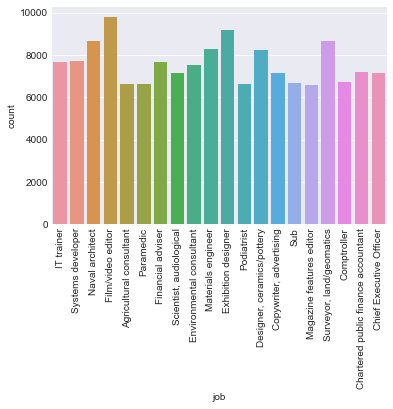

In [27]:
plot = sns.countplot(df[df.job.isin(high_trans_jobs)].job)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.show()

In [30]:
# Job - Fradulent activity plot
df_job = df[['job','trans_num']].groupby(['job']).count().reset_index()
df_job.columns = ['job', 'job_count']

df_fraud_job = df[['job', 'trans_num', 'is_fraud']].groupby(['job','is_fraud']).count().reset_index()
df_fraud_job.columns = ['job', 'is_fraud', 'Transaction count']

df_fraud_job = df_fraud_job.merge(df_job[['job', 'job_count']], how='inner', on='job')

df_fraud_job['Transaction percentage'] = (df_fraud_job['Transaction count']/df_fraud_job['job_count'])*100

# Top 25 jobs with high fraudulent transaction volumes
df_fraud_job[df_fraud_job['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(25)

,job,is_fraud,Transaction count,job_count,Transaction percentage
64,Armed forces technical officer,1,8,8,100.000000
318,"Engineer, site",1,12,12,100.000000
453,Information officer,1,8,8,100.000000
493,Legal secretary,1,12,12,100.000000
450,Industrial buyer,1,10,10,100.000000
111,Careers adviser,1,15,15,100.000000
421,Homeopath,1,11,11,100.000000
94,Broadcast journalist,1,9,9,100.000000
619,Personnel officer,1,12,12,100.000000
374,Forest/woodland manager,1,9,9,100.000000


In [31]:
# Merchants

high_trans_merchants = df.merchant.value_counts().head(20).index.tolist()
high_trans_merchants

['fraud_Kilback LLC',
 'fraud_Cormier LLC',
 'fraud_Schumm PLC',
 'fraud_Kuhn LLC',
 'fraud_Boyer PLC',
 'fraud_Dickinson Ltd',
 'fraud_Cummerata-Jones',
 'fraud_Kutch LLC',
 'fraud_Olson, Becker and Koch',
 'fraud_Stroman, Hudson and Erdman',
 'fraud_Rodriguez Group',
 'fraud_Erdman-Kertzmann',
 'fraud_Jenkins, Hauck and Friesen',
 'fraud_Kling Inc',
 'fraud_Connelly, Reichert and Fritsch',
 'fraud_Friesen-Stamm',
 'fraud_Prohaska-Murray',
 'fraud_Huels-Hahn',
 'fraud_Berge LLC',
 'fraud_Bartoletti-Wunsch']

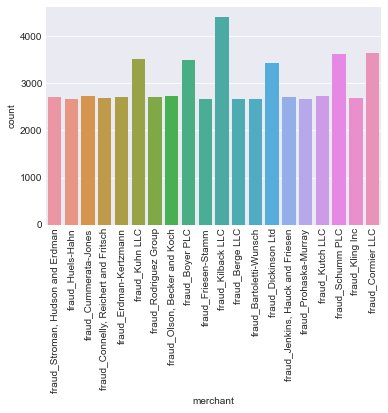

In [32]:
# Plotting the top merchants with high transaction volumes
plot = sns.countplot(df[df.merchant.isin(high_trans_merchants)].merchant)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plt.show()

In [38]:
df.info()

# We have so many object columns, so we have to convert them into numerical columns or we should drop them.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype    
---  ------        --------------    -----    
 0   cc_num        1296675 non-null  int64    
 1   merchant      1296675 non-null  object   
 2   category      1296675 non-null  object   
 3   amt           1296675 non-null  float64  
 4   gender        1296675 non-null  object   
 5   street        1296675 non-null  object   
 6   city          1296675 non-null  object   
 7   state         1296675 non-null  object   
 8   zip           1296675 non-null  int64    
 9   lat           1296675 non-null  float64  
 10  long          1296675 non-null  float64  
 11  city_pop      1296675 non-null  int64    
 12  job           1296675 non-null  object   
 13  trans_num     1296675 non-null  object   
 14  unix_time     1296675 non-null  int64    
 15  merch_lat     1296675 non-null  float64  
 16  merch_long    1296675 non-null  floa

In [42]:
target_encoding_list = ["gender", "age",  "tx_dayofweek"]
le_encoding_list = ["street", "state", "zip", "city", "job", "category"]
unneeded_columns = ["trans_num", "merchant", "cc_num"]

for i in target_encoding_list:
    df[i] = df.groupby([i]).is_fraud.transform("mean")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in le_encoding_list:
    df[i] = le.fit_transform(df[i])
    
customer_numbers = df.cc_num # in case there is any need for that happens, i store it in a variable

df = df.drop(unneeded_columns,1)

In [50]:
df.tx_month = df.tx_month.astype(int)

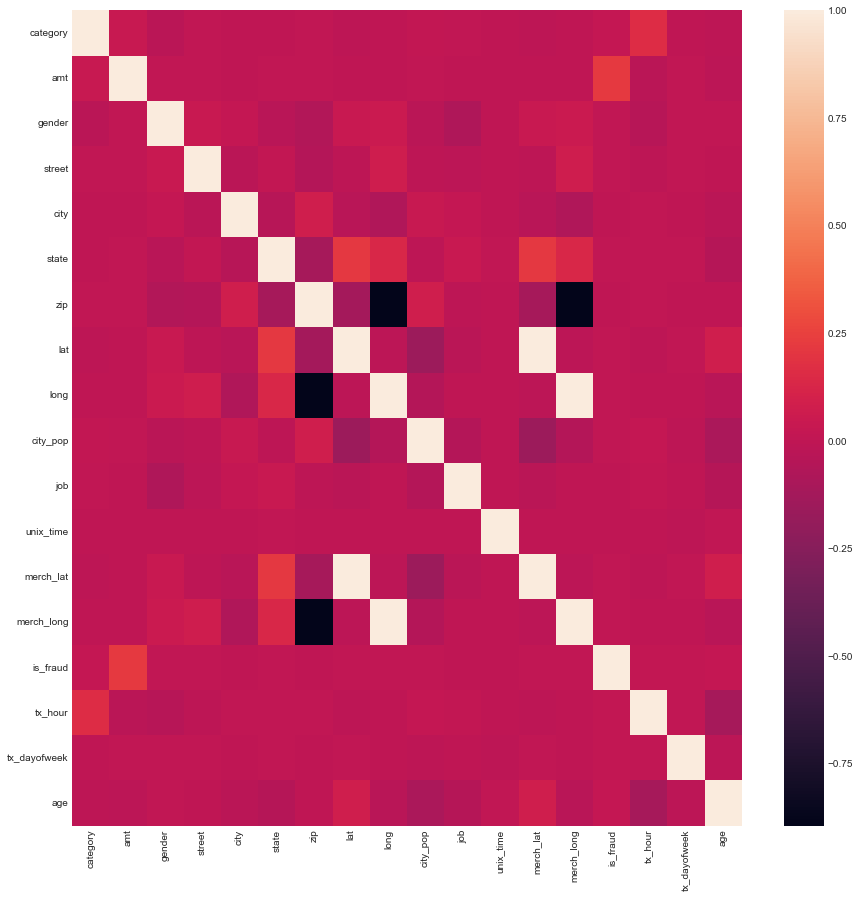

In [44]:
#let us now check the correlations between the columns
df_random_under_corr = df.corr()
#plotting the correlation heatplot
plt.figure(figsize=(15,15))
sns.heatmap(df_random_under_corr)
plt.show()

### Building Model

In [51]:
# target variable and train variables

X = df.drop(['is_fraud'],axis=1)
y = df.is_fraud

In [52]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

### Logistic Regression

In [55]:
lr = LogisticRegression(random_state=42)
model_lr = lr.fit(X_train, y_train)
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

y_train_pred:  [0 0 0 ... 0 0 0]
y_test_pred:  [0 0 0 ... 0 0 0]


In [56]:
model_name = 'Logistic Regression'

train_score = model_lr.score(X_train,y_train)
test_score = model_lr.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
# Creating a dataframe

model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall'])
evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.993673,0.993603,0.993603,0.990949,0.000000,0.000000


### LightGBM

In [57]:
import lightgbm as lgbm

model_lgbm = lgbm.LGBMClassifier(objective = "binary", is_unbalanced = True)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

[LightGBM] [Warning] Unknown parameter: is_unbalanced


In [59]:
model_name = 'LightGBM'

train_score = model_lr.score(X_train,y_train)
test_score = model_lr.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
roc_auc = metrics.roc_auc_score(y_test,y_test_pred)
# Creating a dataframe

model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall, roc_auc]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall', "Roc-Auc"])
evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall,Roc-Auc
0,LightGBM,0.993673,0.993603,0.997127,0.997093,0.767426,0.731579,0.865136


### XGBoost

In [61]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

[20:33:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [62]:
model_name = 'XGBoost'

train_score = model_xgb.score(X_train,y_train)
test_score = model_xgb.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
roc_auc = metrics.roc_auc_score(y_test,y_test_pred)
# Creating a dataframe

model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall, roc_auc]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall', "Roc-Auc"])
evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall,Roc-Auc
0,XGBoost,0.999373,0.998785,0.998785,0.998738,0.963818,0.823684,0.911751


### Decision Tree Classifier

In [63]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

y_train_pred = model_dt.predict(X_train)
y_test_pred = model_dt.predict(X_test)

In [64]:
model_name = 'Decision Tree Classifier'

train_score = model_dt.score(X_train,y_train)
test_score = model_dt.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
roc_auc = metrics.roc_auc_score(y_test,y_test_pred)
# Creating a dataframe

model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall, roc_auc]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall', "Roc-Auc"])
evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall,Roc-Auc
0,Decision Tree Classifier,1.000000,0.997629,0.997629,0.997646,0.789137,0.812500,0.905610


In [65]:

dt_y_test_pred = model_dt.predict(X_test)
xgb_y_test_pred = model_xgb.predict(X_test)
lgbm_y_test_pred = model_lgbm.predict(X_test)
lr_y_test_pred = model_lr.predict(X_test)

In [80]:
# Custom function for creating comparison df
def custom(y_train, y_test_pred):
    acc_score = accuracy_score(y_test,y_test_pred)
    f_score = f1_score(y_test, y_test_pred, average='weighted')
    precision = precision_score(y_test, y_test_pred)
    recall = metrics.recall_score(y_test,y_test_pred)
    roc_auc = metrics.roc_auc_score(y_test,y_test_pred)
    model_eval_data = [[acc_score, f_score, precision, recall, roc_auc]]
    return model_eval_data

In [72]:
comparison_list = []
comparison_list.append([custom(y_train, dt_y_test_pred)[0], custom(y_train, xgb_y_test_pred)[0], custom(y_train, lgbm_y_test_pred)[0],
            custom(y_train, lr_y_test_pred)[0]])

In [78]:
comparison_df = pd.DataFrame(comparison_list[0]).T
comparison_df.columns  = ["DecisionTree", "XGBoost", "LightGBM", "LogisticRegression"]
comparison_df.index = ["Accuracy", "F1_Score", "Precision", "Recall", "Roc-Auc"]

In [79]:
comparison_df

,DecisionTree,XGBoost,LightGBM,LogisticRegression
Accuracy,0.997629,0.998785,0.997127,0.993603
F1_Score,0.997646,0.998738,0.997093,0.990949
Precision,0.789137,0.963818,0.767426,0.000000
Recall,0.812500,0.823684,0.731579,0.000000
Roc-Auc,0.905610,0.911751,0.865136,0.499730
